# Solving The Titanic Competition with XGB
### Muhammad Ezzat




### Importing Needed Modules


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### Importing Data



In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.info())
test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


(418, 11)

### Exploring Missing Values

What I go by is simple, if the missing values are few drop the rows, if they are the vast majority drop the
cloumn, otherwise use imputation. So I'll drop the column Cabin, drop the row where embarked is missing & explore the Age
variable more to identify the suitable imputation method.


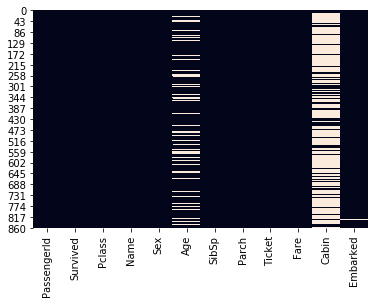

In [3]:
sns.heatmap(train.isnull(), cbar=False)

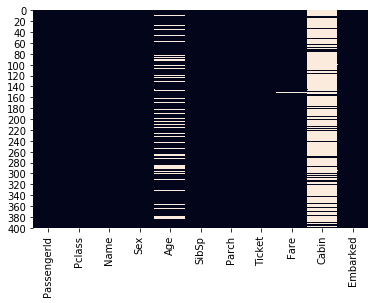

In [4]:
sns.heatmap(test.isnull(), cbar=False)

### Dropping Missing Values 



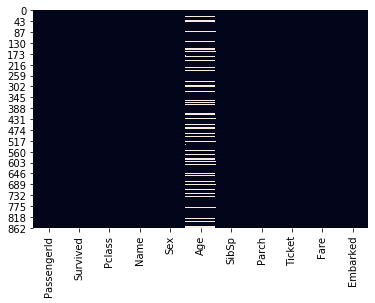

In [5]:
train =  train.drop(columns = ['Cabin'],axis=1)
test =  test.drop(columns = ['Cabin'],axis=1)
train = train.dropna(axis = 0,subset=['Embarked'],how='any')
sns.heatmap(train.isnull(), cbar=False)


In [6]:
(train.Age.isnull().sum() / train.shape[0])*100

19.910011248593925

So nearly 20% of the age data is missing, we can't afford dropping 20% of data. We will use mean/median imputation


### Median imputation


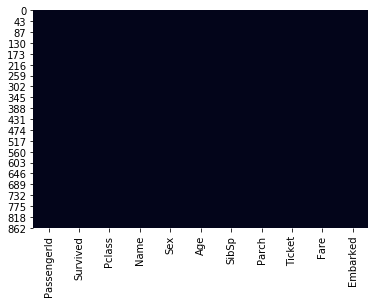

In [7]:
train['Age'].fillna( train['Age'].median() , inplace=True)
test['Age'].fillna( train['Age'].median() , inplace=True)
test['Fare'].fillna( train['Fare'].median() , inplace=True)

sns.heatmap(train.isnull(), cbar=False)

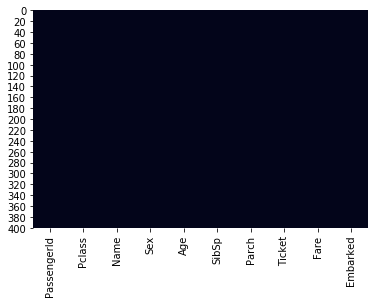

In [8]:
sns.heatmap(test.isnull(), cbar=False)

So now we don't have any missing values, let's continue our exploration.



In [9]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,29.315152,0.524184,0.382452,32.096681
std,256.998173,0.486260,0.834700,12.984932,1.103705,0.806761,49.697504
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Encoding Categorical variables & Dropping unnecessary variables


For the vast majority of machine learning algorithms it's always better to encode meaningful categorical variable while dropping those who don't have logical impact eg : names, id's ..etc .

In [10]:
# Age
train["Sex"]= np.where(train["Sex"]=="female",0,1)
test["Sex"]= np.where(test["Sex"]=="female",0,1)
# Name
train =  train.drop(columns = ['Name'],axis=1)
test =  test.drop(columns = ['Name'],axis=1)
# Ticket Number
train =  train.drop(columns = ['Ticket'],axis=1)
test =  test.drop(columns = ['Ticket'],axis=1)
# Id
ID =test.PassengerId
train =  train.drop(columns = ['PassengerId'],axis=1)
test =  test.drop(columns = ['PassengerId'],axis=1)
# Embarked
train["Embarked"]= np.where(train["Embarked"]=="C",1,np.where(train["Embarked"]=="S",2,3))
test["Embarked"]= np.where(test["Embarked"]=="C",1,np.where(test["Embarked"]=="S",2,3))


train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


### Separating the response variable
As the XGB frame is very similar to scikit-learn one, we have to separate explanatory variables from response.

In [11]:
X_train =  train.drop(columns = ['Survived'],axis=1)
y_train = train.Survived
X_test = test


## We got it all set, let's go XGBOOSTING !


In [12]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

This is called gridsearch, an exhaustive search for the best set of hyper-parametes from parameter grid given through cross validation.

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

In [13]:
model = xgb.XGBClassifier()
params = {
    'learning_rate' :[0.2,0.02,0.002],
    'max_depth': [3, 4, 5],
    'n_estimators' :[50,100,150]
}
SCV = GridSearchCV(estimator = model,param_grid = params,scoring='accuracy',cv=10,verbose=1)
SCV.fit(X_train,y_train)
print("Best parameters found: ", SCV.best_params_)
print("Best accuracy : ", SCV.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best accuracy :  0.8256467941507312


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   12.7s finished


### Training, predicting, saving submission
The data from the kaggle competiton didn't have the y_test column so I couldn't calculate my quality metrics, anyway you can see that validation socre was 82% which is relatively high in the Titanic Problem. However on kaggle testing it scored nearly 76 % placing me in the 135th position in the leaderboard. Not bad for my first ever submission. :D

In [17]:
#training
model = xgb.XGBClassifier( learning_rate= 0.2 , max_depth=3, n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
#saving results
y_pred = np.array(y_pred)
submission = {'PassengerId':ID,'Survived':y_pred}
submission = pd.DataFrame(submission)
submission.to_csv("Submission.csv", index=False)


# That was it !! Thank you for going through the notebook :)
